<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/LangGraph_Human_in_the_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human In The Loop

- https://blog.langchain.dev/human-in-the-loop-with-opengpts-and-langgraph/

- https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-4-human-in-the-loop

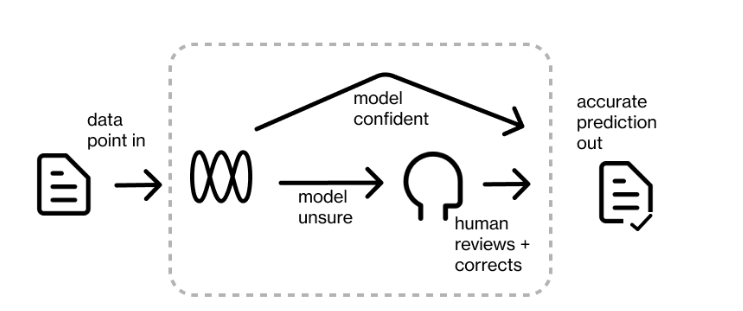


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic langchain_openai langchain-google-genai

In [ ]:
import getpass
import os
from google.colab import userdata

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(f"{var}")


os.environ["OPENAI_API_KEY"] =  userdata.get("KEY_OPENAI")
os.environ["ANTHROPIC_API_KEY"]=  userdata.get("ANTROPIC_KEY")
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

# LangSmith for tracing.

https://docs.smith.langchain.com/observability/concepts

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-react-agent"

In [ ]:

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

In [ ]:
# Get user input
try:
    user_input = input("Tell me how you want to update the state: ")
except:
    user_input = "go to step 3!"

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"user_feedback": user_input}, as_node="human_feedback")

# We can check the state
print("--State after update--")
print(graph.get_state(thread))

# We can check the next node, showing that it is node 3 (which follows human_feedback)
graph.get_state(thread).next

In [ ]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

In [ ]:
graph.get_state(thread).values

In [ ]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation

    return f"I looked up: {query}. Result: It's sunny in San Francisco, it is cloudy in London and I dont know if other."
@tool
def add(x: int, y: int):
    """Add two numbers."""


    return f"I added {x} and {y} and got {x+y}"


tools = [search,add]
tool_node = ToolNode(tools)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
# Set up the model
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = ChatOpenAI(model="gpt-4o")

# model = ChatGoogleGenerativeAI(
#     model="gemini-1.5-pro",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     google_api_key=GEMINI_API_KEY,
#     streaming=True,
#     verbose=True,
# )

In [ ]:
from pydantic import BaseModel


# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

In [ ]:
# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    pass


# Build the graph

In [ ]:


from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # We may ask the human
        "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory, interrupt_before=["ask_human"])

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(
    content="Ask the user what he wants to do. Use search tool to ask the user where they are, then look up the weather there or use the add tool if the user ask you to sum up two numbers"
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
app.get_state(config).values["messages"]

In [ ]:
app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

In [ ]:
tool_call_id = app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

# We now create the tool call with the id and the response we want
tool_message = [
    {"tool_call_id": tool_call_id, "type": "tool", "content": "What it is the weather in London"}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="London")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
app.update_state(config, {"messages": tool_message}, as_node="ask_human")

# We can check the state
# We can see that the state currently has the `agent` node next
# This is based on how we define our graph,
# where after the `ask_human` node goes (which we just triggered)
# there is an edge to the `agent` node
app.get_state(config).next

In [ ]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
app.get_state(config).values["messages"]

In [ ]:
input_message = HumanMessage(
    content="Ask the user what he wants to do. Use search tool to ask the user where they are, then look up the weather there or use the add tool if the user ask you to sum up two numbers"
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
tool_call_id = app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

# We now create the tool call with the id and the response we want
tool_message = [
    {"tool_call_id": tool_call_id, "type": "tool", "content": "I have 5 apples, I buy 7 more , how many apples I have?"}
]
app.update_state(config, {"messages": tool_message}, as_node="ask_human")

# We can check the state
# We can see that the state currently has the `agent` node next
# This is based on how we define our graph,
# where after the `ask_human` node goes (which we just triggered)
# there is an edge to the `agent` node
app.get_state(config).next

In [ ]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
app.get_state(config).values["messages"]

In [ ]:
app.get_state(config).next

In [ ]:
! pip install tavily-python langchain_community -q U

In [ ]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

In [ ]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
existing_message = snapshot.values["messages"][-1]
existing_message